# Dynex Quantum Support Vector Machine (Tensorflow layer)

in this example a classical classiﬁcation model, Kernel-Support Vector machine, is implemented as a Quadratic Unconstrained Binary Optimisation problem. Here, data points are classiﬁed by a separating hyperplane while maximizing the function margin. The problem is solved for a public Banknote Authentication dataset.

In [1] the authors performed benchmark tests for a Quantum-SVM on multiple D-Wave Quantum machines.

We will demonstrate that the Dynex Neuromorphic Computing platform, by using the Dynex QSVM Tensorflow Layer, will significantly outperform these results.

## QSVM using the Dynex QSVM Tensorflow Layer

In [1]:
import math
import tensorflow as tf
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from QSVM_Layer import QSVM_Layer

2023-12-29 23:04:18.234653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 23:04:18.973561: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Dataset Function

In [2]:
# create a tensorflow dataset
class BankDataset():
	def __init__(self, data_file):
		"""
        this function define the BankDataset class from a text or CSV file 

        Parameters
        ----------
        data_file : the data file to be loaded

        """
		training_data = np.loadtxt('./datasets/{}'.format(data_file), delimiter=',')
		for i in range(len(training_data)):
			if(training_data[i][-1] == 0):
				training_data[i][-1] = -1
		data = training_data[:, :2]
		target = training_data[:, -1]
		x_min, x_max = 1000, 0
		y_min, y_max = 1000, 0
    	# rescalling data
		for i in range(len(training_data)):
			x_min = min(data[i][0], x_min)
			x_max = max(data[i][0], x_max)
			y_min = min(data[i][1], y_min)
			y_max = max(data[i][1], y_max)
		for i in range(len(training_data)):
			data[i][0] = (data[i][0] - x_min)/(x_max - x_min)
			data[i][1] = (data[i][1] - y_min)/(y_max - y_min)
        
		self.data = data
		self.target = target	

	def to_tf_dataset(self, batch_size=1, shuffle=True):
		dataset = tf.data.Dataset.from_tensor_slices((self.data, self.target))
		if shuffle:
			dataset = dataset.shuffle(buffer_size=len(self.data))
		dataset = dataset.batch(batch_size)
		return dataset

## Initialize the train, validation, and test data loaders with Tensorflow

In [3]:
# Initialize the BankDataset
bank_dataset = BankDataset(data_file='banknote.txt')

# Split the dataset into train and test sets
train_percent = 0.8
train_size = int(len(bank_dataset.data) * train_percent)
test_size = len(bank_dataset.data) - train_size

# Using TensorFlow for splitting the dataset
#full_dataset = tf.data.Dataset.from_tensor_slices((bank_dataset.data, bank_dataset.labels))
full_dataset = bank_dataset.to_tf_dataset(batch_size=1, shuffle=True)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

# Convert to TensorFlow datasets with batching
train_dataset = train_dataset.batch(1).shuffle(train_size)
test_dataset = test_dataset.batch(1)

2023-12-29 23:04:20.886527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 23:04:20.917661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 23:04:20.917839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Define Tensorflow model with a custom Dynex-QSVM layer

In [4]:
class QSVM_Model(tf.keras.Model):
  def __init__(self, B,K,C,gamma,xi,bank_dataset,train_percent,spl,mainnet,num_reads,annealing_time):
    
    super(QSVM_Model, self).__init__()
    self.qsvm_layer = QSVM_Layer(B,K,C,gamma,xi,bank_dataset,train_percent,spl,mainnet,num_reads,annealing_time)

  def call(self, x):
    x = self.qsvm_layer(x) 
    return x

## Settings

In [5]:
B = 2;
K = 2;
C = 3;
gamma = 16;
xi = 0.001;
spl = "DNX";     
device = "cpu" # no GPU used for Dynex only
mainnet = False
num_reads=20000 
annealing_time = 200

## Training

In [6]:
### train a new model on the train dataset
model = QSVM_Model(B,K,C,gamma,xi,bank_dataset,train_percent,spl,mainnet,num_reads,annealing_time)
EPOCHS = 1
for e in range(0, EPOCHS):
	print("training a new model...")
	print('EPOCH',e+1,'of',EPOCHS);
	tp, fp, tn, fn = 0, 0, 0, 0
	# training a model on dataset
	model.qsvm_layer.train(save_model=True, save_path='./models', model_file='QSVM.model')
	print("training end")
	# predict on test dadaset
	for (x, y) in test_dataset:
		## remove batch dim
		x = tf.reshape(x, [x.shape[1], x.shape[2]])
		# perform a forward pass
		pred = model(x);
		if(y == 1):
			if(pred > 0):
				tp += 1
			else:
				fp += 1
		else:
			if(pred < 0):
				tn += 1
			else:
				fn += 1
	print("test dataset result:")				
	precision = tp / (tp + fp)
	recall = tp / (tp + fn)
	f_score = tp/(tp + 1/2*(fp+fn))
	accuracy = (tp + tn)/(tp+tn+fp+fn)
	print(f"{precision=} {recall=} {f_score=} {accuracy=}")

training a new model...
EPOCH 1 of 1
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬─────────────┬───────────┬───────────────────────────┬─────────┬─────────┬────────────────╮
│   DYNEXJOB │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CHIPS   │ STEPS   │ GROUND STATE   │
├────────────┼─────────────┼───────────┼───────────────────────────┼─────────┼─────────┼────────────────┤
│         -1 │           0 │           │ *** WAITING FOR READS *** │         │         │                │
╰────────────┴─────────────┴───────────┴───────────────────────────┴─────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.01 SECONDS
[DYNEX] SAMPLESET READY
Solver Time: 17.972045780999906
training end
test dataset result:
precision=1.0 recall=1.0 f_score=1.0 accuracy=1.0


## The Dynex Platorm achieved scores of 1.0 for every metric

## Plot Results

In [7]:
def plot_figure(SVM,dataset,train_percent,sampler_type, img):
	"""
    This function plot a contour image for dataset.
    Parameters:
    - SVM: the trained SVM model.
    - dataset: dataset for train and test.
    - train_percent: the percentage of dataset size for training.
    - sampler_type: sampler type.
    - img: Path to save the image.
    """
	plt.figure()
	cm = plt.cm.RdBu
	data = dataset.data
	t = dataset.target
	N = int(len(dataset.data)*train_percent)
	xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 80), np.linspace(0.0, 1.0, 80))
	Z = []
	for row in range(len(xx)):
		Z_row = []
		for col in range(len(xx[row])):
			target = np.array([xx[row][col], yy[row][col]])
			Z_row.append(SVM(target))
		Z.append(Z_row)
	
	cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
	plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
	plt.colorbar(cnt, ticks=[-1, 0, 1])

	red_sv = []
	blue_sv = []
	red_pts = []
	blue_pts = []

	for i in range(N):
		if(SVM.alpha[i]):
			if(t[i] == 1):
				blue_sv.append(data[i, :2])
			else:
				red_sv.append(data[i, :2])
		else:
			if(t[i] == 1):
				blue_pts.append(data[i, :2])
			else:
				red_pts.append(data[i, :2])

	plt.scatter([el[0] for el in blue_sv],
                [el[1] for el in blue_sv], color='b', marker='^', edgecolors='k', label="Type 1 SV")

	plt.scatter([el[0] for el in red_sv],
                [el[1] for el in red_sv], color='r', marker='^', edgecolors='k', label="Type -1 SV")

	plt.scatter([el[0] for el in blue_pts],
                [el[1] for el in blue_pts], color='b', marker='o', edgecolors='k', label="Type 1 Train")

	plt.scatter([el[0] for el in red_pts],
                [el[1] for el in red_pts], color='r', marker='o', edgecolors='k', label="Type -1 Train")    
	plt.legend(loc='lower right', fontsize='x-small')
	plt.savefig(f'{img}.jpg')

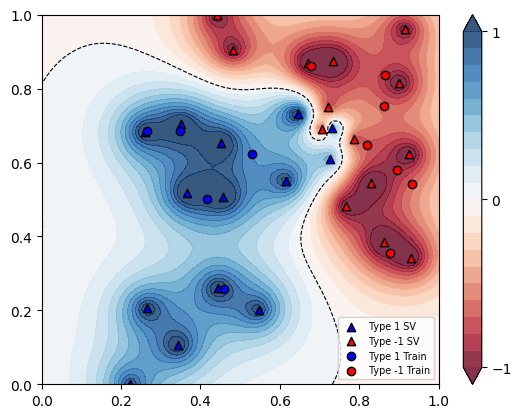

In [8]:
plot_figure(model.qsvm_layer,bank_dataset,train_percent,spl,"img")

In [10]:
def predict(model,model_file,dataset):
	"""
        This function predict a trained SVM result for a dataset.

        Parameters:
            - model: the trained SVM model.
            - model_file: the file saved a trained model.
            - dataset: the dataset for predict.
    """
	model.load_model(model_file)
	tp, fp, tn, fn = 0, 0, 0, 0
	for (x, y) in dataset:
		# send the input to the device
		x = tf.reshape(x, [x.shape[1], x.shape[2]])
		# perform a forward pass and calculate the training loss
		pred = model(x);
		if(y == 1):
			if(pred > 0):
				tp += 1
			else:
				fp += 1
		else:
			if(pred < 0):
				tn += 1
			else:
				fn += 1

	precision = tp / (tp + fp)
	recall = tp / (tp + fn)
	f_score = tp/(tp + 1/2*(fp+fn))
	accuracy = (tp + tn)/(tp+tn+fp+fn)
	print("precision result:")
	print(f"{precision=} {recall=} {f_score=} {accuracy=}") 
## load a saved model to predict on test dataset
print("make a predict on a saved model...")
predict(model.qsvm_layer, './models/QSVM.model', test_dataset)

make a predict on a saved model...
precision result:
precision=0.8571428571428571 recall=1.0 f_score=0.9230769230769231 accuracy=0.9


## References

[1] Harshil Singh Bhatia and Frank Phillipson: Performance Analysis of Support Vector Machine Implementations on the D-Wave Quantum Annealer, International Conference on Computational Science, p.84-97, 2021, Springer

[2] Booth, M., Reinhardt, S.P., Roy, A.: Partitioning Optimization Problems for Hybrid Classical/Quantum Execution. Technical report, D-Wave Systems (2017)

[3] Chang, C.C., Lin, C.J.: LIBSVM: a library for support vector machines. ACM Trans. Intell. Syst. Technol. 2, 27:1–27:27.

[4] Chatterjee, R., Yu, T.: Generalized coherent states, reproducing kernels, and quantum support vector machines. Quantum Inf. Comput. 17(15–16), 1292–1306 (2017)

[5] Choi, V.: Minor-embedding in adiabatic quantum computation: I. the parameter setting problem. Quantum Inf. Process. 7(5), 193–209 (2008)

[6] Coﬀrin, C.J.: Challenges with chains: testing the limits of a d-wave quantum annealer for discrete optimization. Technical report, Los Alamos National Lab. (LANL), Los Alamos, NM (United States) (2019)

[7] Willsch, D., Willsch, M., De Raedt, H., Michielsen, K.: Support vector machines on the d-wave quantum annealer. Comput. Phys. Commun. 248, 107006 (2020)